# Brazilian E-commers Data Visualization

## Preparing notebook

### Importing libraries to use

In [1]:
# REQUIRED LIBRARIES 
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns
import folium  #needed for interactive map
from folium.plugins import HeatMap

# CONNECTION TO THE DATABASE
try:
    conn = psycopg2.connect(
        host = "ec2-54-157-79-121.compute-1.amazonaws.com",
        database = "d42ekpicafpt4b",
        user = "okskipddgcuaix",
        password = "f4389a6257140d0f66be8163b27d131299ec2aa73455aa07991669ea689eb008"
        )

    print("Successful connection")
    #cursor = conn.cursor()
    #row = cursor.fetchone()
    #print(row)

except Exception as ex:
    print(ex)

Successful connection


### Selecting the tables

In [2]:
# SELECT THE TABLES FROM THE DATABASE

city_state_table = "SELECT * FROM city_state_table"
code_zip_prefix_table = "SELECT * FROM code_zip_prefix_table"
customers_table = "SELECT * FROM customers_table"
geolocation_table = "SELECT * FROM geolocation_table"
order_items_table = "SELECT * FROM order_items_table"
order_payments_table = "SELECT * FROM order_payments_table"
order_reviews_table = "SELECT * FROM order_reviews_table"
orders_table = "SELECT * FROM orders_table"
products_category_name_table= "SELECT * FROM products_category_name_table"
products_table = "SELECT * FROM products_table"
sellers_table = "SELECT * FROM sellers_table"
state_table = "SELECT * FROM state_table"
unique_order_id_table = "SELECT * FROM unique_order_id_table"

### Transforming tables to dataframes

In [3]:
# TRANSFORM SQL QUERIES TO PANDAS DATAFRAMES

df_city_state = pd.io.sql.read_sql_query(city_state_table, conn)
df_code_zip = pd.io.sql.read_sql_query(code_zip_prefix_table, conn)
df_customers = pd.io.sql.read_sql_query(customers_table, conn)
df_geolocation = pd.io.sql.read_sql_query(geolocation_table, conn)
df_order_items = pd.io.sql.read_sql_query(order_items_table, conn)
df_payments = pd.io.sql.read_sql_query(order_payments_table, conn)
df_reviews = pd.io.sql.read_sql_query(order_reviews_table, conn)
df_orders = pd.io.sql.read_sql_query(orders_table, conn)
df_products_category = pd.io.sql.read_sql_query(products_category_name_table, conn)
df_products = pd.io.sql.read_sql_query(products_table, conn)
df_sellers = pd.io.sql.read_sql_query(sellers_table, conn)
df_state = pd.io.sql.read_sql_query(state_table, conn)
df_unique_order = pd.io.sql.read_sql_query(unique_order_id_table, conn)

In [4]:
# LIST OF CATEGORIES NAMES

list_of_categories = df_products_category.product_category_name_english.unique()

### Merging customers tables with state table

In [5]:
# MERGE BEETWEEN CUSTROMERS TABLE AND STATE TABLE

customers_short = df_customers[['customer_state_id', 'customer_id']]
customers_short.columns = ['state_id', 'customer_id']
customers_per_state = pd.merge(customers_short, df_state, how='left')

## Customers

### Barchar of customers by state

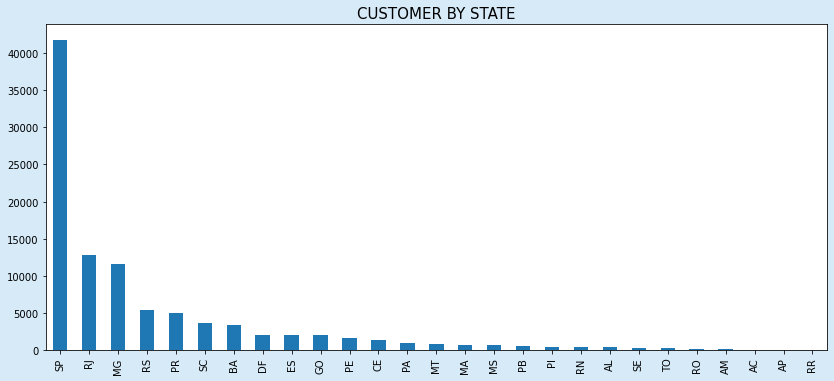

In [6]:
# CUSTOMERS BY STATE GRAPH

bar_one = customers_per_state.state.value_counts()
fig = plt.subplots(figsize = (14,6), facecolor='#D6EAF8')
plt.title("CUSTOMER BY STATE", fontdict = {'fontsize': 15})
bar_one.plot.bar()
plt.show()

### Pie chart of customers by state

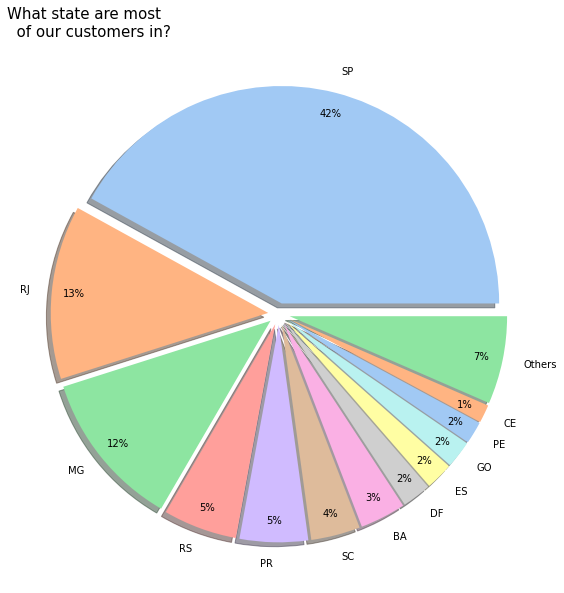

In [7]:
# PIE CHART OF CUSTOMERS BY STATE

df1 = customers_per_state.groupby(by='state').count().reset_index()
df1['percent'] = df1.state_id / df1.state_id.sum()
df1 = df1.sort_values(by='state_id', ascending=False).reset_index(drop=True)
dff = df1[0:12].drop(['customer_id'], axis=1)
dfl= df1[['percent', 'state_id']][12:27].sum()
dfl = pd.DataFrame([['Others', dfl[1], dfl[0]]], columns=['state','state_id','percent'])
dft = pd.concat([dff, dfl]).reset_index(drop=True)
fig_pctj = plt.figure(figsize=(10, 10))
colors = sns.color_palette('pastel')
#explode=dft['percent']
explode = [0.05] * len(dft['state'])
plt.pie(dft['state_id'], labels=dft['state'],colors = colors, autopct = '%0.0f%%', explode=explode, shadow = 'True', pctdistance=0.9)
plt.title('What state are most\n  of our customers in?', loc='left', fontdict = {'fontsize': 15})
plt.show()

### Heatmap of customers' locations

In [8]:
# FILTERING POSSIBLES OUTLIERS

df_geo_customers = df_geolocation

df_geo_customers = df_geolocation[
    (df_geolocation['geolocation_lat'] <= 5.27438888) &
    (df_geo_customers['geolocation_lng'] >= -73.98283055) &
    (df_geo_customers['geolocation_lat'] >= -33.75116944) &
    (df_geo_customers['geolocation_lng'] <=  -34.79314722)
]

In [9]:
# ORDERING DATA IN DATAFRAMES TO PLOT

geolocation_customers = df_geo_customers[['geolocation_code_zip_prefix_id','geolocation_lat', 'geolocation_lng',]]
geolocation_customers.columns = ['customer_zip_code_prefix_id','geolocation_lat', 'geolocation_lng',]
geo = geolocation_customers.groupby(by='customer_zip_code_prefix_id').mean().reset_index()
customers = df_customers.groupby(by='customer_zip_code_prefix_id').count().reset_index()
customers = customers[['customer_zip_code_prefix_id', 'customer_id']]
geo_customers = pd.merge(customers, geo, how='inner')

#Creating map with the start coordinates from Brazil and adjusted zoom
folium_map = folium.Map(location=[-14.235004, -51.92528],
                        zoom_start=4,
                        min_zoom = 4,
                        max_zoom = 10,
                        )
my_zip = zip(geo_customers['geolocation_lat'], geo_customers['geolocation_lng'], geo_customers['customer_id'])
list_of_my_zip = list(my_zip)
hm_layer = HeatMap(list_of_my_zip,
                   # These are parameters that we tweak manually to adjust color
                   # See folium docs for more information
                   min_opacity=0.2,
                   radius=8,
                   blur=6, 
                 )
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Our Customers Location</b></h3>
             '''
folium_map.get_root().html.add_child(folium.Element(title_html))
folium_map.add_child(hm_layer)
folium_map

## Sellers

### Merging sellers table with state table

In [10]:
# MERGE BEETWEEN SELLERS TABLE AND STATE TABLE

sellers_short = df_sellers[['seller_city_state_id', 'seller_id']]
sellers_short.columns = ['city_state_id', 'seller_id']
city_short = df_city_state[['city_state_id', 'state_id']]

sellers_and_cities = pd.merge(sellers_short, city_short, how='left')
sellers_per_state = pd.merge(sellers_and_cities, df_state, how = 'left')

### Barchart of sellers by state

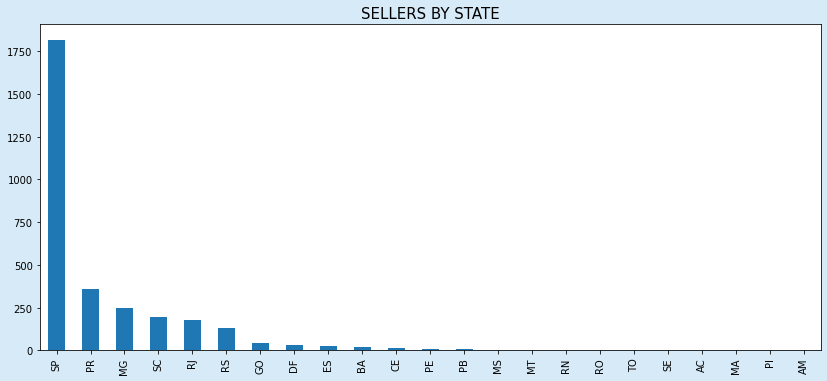

In [11]:
# BAR CHART OF SELLERS BY STATE

bar_two = sellers_per_state.state.value_counts()
fig = plt.subplots(figsize = (14,6), facecolor='#D6EAF8')
plt.title("SELLERS BY STATE", {'fontsize': 15})
bar_two.plot.bar()
plt.show()

### Pie chart of sellers by state

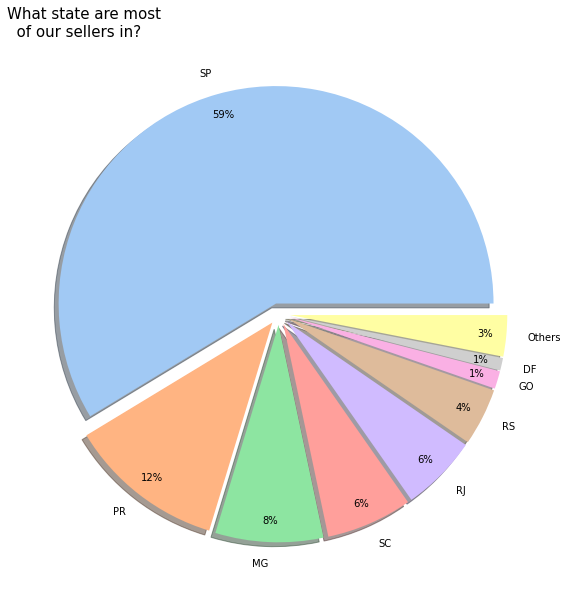

In [12]:
sellers_per_state_counts = pd.DataFrame(sellers_per_state.state.value_counts().reset_index())
sellers_per_state_counts.columns = ['state', 'sellers']

first_8 = sellers_per_state_counts[:8]
others = sellers_per_state_counts.iloc[8:, 1].sum()
pd_new_row = pd.DataFrame(data = {
    'state': ['Others'],
    'sellers': [others],
}, index = [8])

first_9 = first_8.append(pd_new_row)

fig = plt.figure(figsize = (10,10))
colors = sns.color_palette('pastel')
labels = first_9.state
explode = [0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05]
plt.pie(first_9['sellers'], labels = labels, colors = colors, autopct = '%0.0f%%', shadow = 'True', pctdistance=0.9, explode = explode)
plt.title('What state are most\n  of our sellers in?', loc='left', fontdict = {'fontsize': 15})
plt.show()

As we can saw in the previous graphs, the majority of the customers and sellers are ubicate in Sao Paulo, Rio de Janeiro, Minas Gerais, Rio Grande do Sul and Parana state so in order to decrease the costs, we should focuss our attention in these areas

## Payment types

### Pie chart of payment types

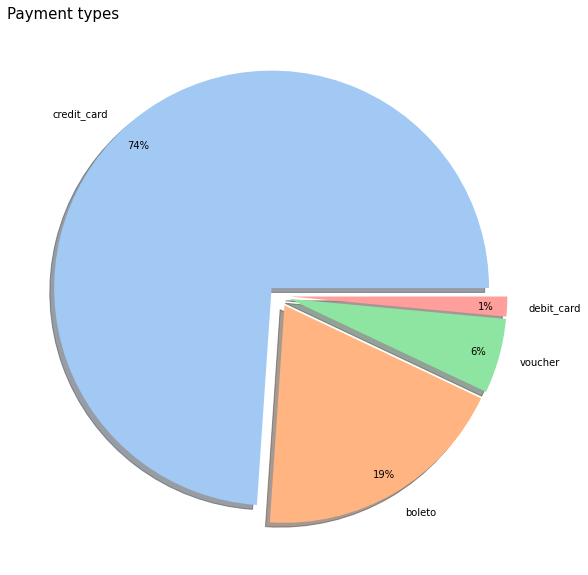

In [13]:
method_of_payment = df_payments[df_payments.payment_type != 'not_defined']
method_of_payment = method_of_payment[['payment_type', 'payment_value']]

graph_pie = pd.DataFrame(method_of_payment.payment_type.value_counts())

fig = plt.subplots(figsize = (10,10))
plt.title("Payment types", loc='left', fontdict = {'fontsize': 15})
colors = sns.color_palette('pastel')
labels = graph_pie.index
explode = [0.05,0.05,0.05,0.05]
plt.pie(graph_pie['payment_type'], labels = labels, colors = colors, autopct = '%0.0f%%', shadow = 'True', pctdistance=0.9, explode=explode)
plt.show()

### Barchart of average payment by payment type

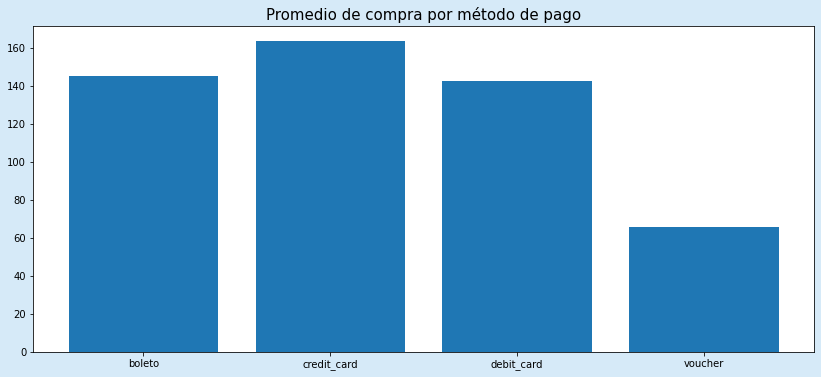

In [14]:
# GRAPH OF AVERAGE PAYMENT BY PAYMENT TYPE

method_of_payment_mean = pd.DataFrame(method_of_payment.groupby('payment_type').mean())

fig = plt.subplots(figsize = (14,6), facecolor='#D6EAF8')
plt.title('Promedio de compra por método de pago', fontdict = {'fontsize': 15})
x = method_of_payment_mean.index
y = method_of_payment_mean.payment_value
plt.bar(x, y)
plt.show()

### Total of payments by payment types

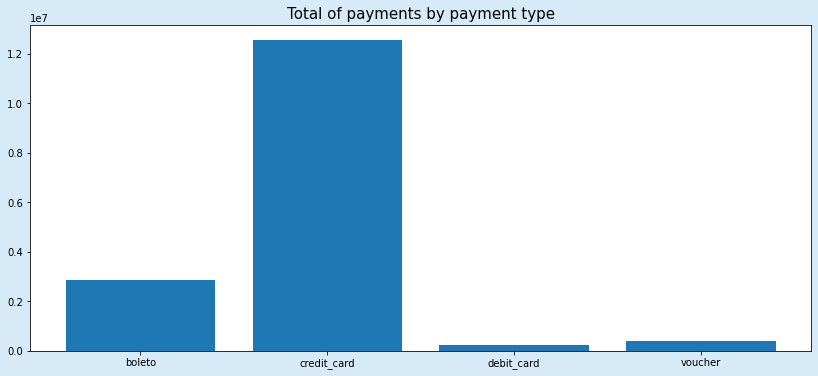

In [15]:
# GRAPH OF TOTAL OF PAYMENTS BY PAYMENT TYPE

method_of_payment_sum = pd.DataFrame(method_of_payment.groupby('payment_type').sum().round())

fig = plt.subplots(figsize = (14,6), facecolor='#D6EAF8')
plt.title('Total of payments by payment type', fontdict = {'fontsize': 15})
x = method_of_payment_sum.index
y = method_of_payment_sum.payment_value
plt.bar(x, y)
plt.show()

The most used method of payment is credit card and boleto is the second most used. The average of payments made by credit card, boleto and debit card are pretty similar, meanwhile voucher is the least used, so we should ignore this method of payment and only center our attention in the other three

### Creating reviews by category table

In [16]:
#UNION DE LAS COLUMNAS PRODUCT ID Y PRODUCT CATEGORY NAME

category_short = df_products_category[['category_id','product_category_name_english']]
products_short = df_products[['product_id', 'product_category_name_id']].dropna()
products_short.columns = ['product_id','category_id']

product_id_and_name = pd.merge(products_short, category_short, how = 'left')
product_id_and_name = product_id_and_name[['product_id', 'product_category_name_english']]

In [17]:
#UNION DE LAS COLUMNAS ORDER, ITEM AND PRODUCT CATEGORY

items_short = df_order_items[['product_id','order_id','item_id']].drop_duplicates()
items_and_category = pd.merge(product_id_and_name, items_short, how = 'left')

In [18]:
#UNION DE ITEMS CATEGORY Y REVIEWS

reviews_short = df_reviews[['review_id','review_score','order_id']]
reviews_per_category = pd.merge(items_and_category, reviews_short, how='left')

### Dynamic pie chart of payment type by category

In [19]:
#UNION DE PAYMENT TYPE Y CATEGORY NAME
df_payments = df_payments[df_payments.payment_type != 'not_defined']

payments_short = df_payments[['order_id','payment_type','payment_value']].drop_duplicates()
items_and_category2 = items_and_category[['order_id', 'product_category_name_english']].drop_duplicates()
payments_per_category = pd.merge(payments_short, items_and_category2, how='left')

In [24]:
categoria_metodo_pago = 'fashion_bags_accessories'

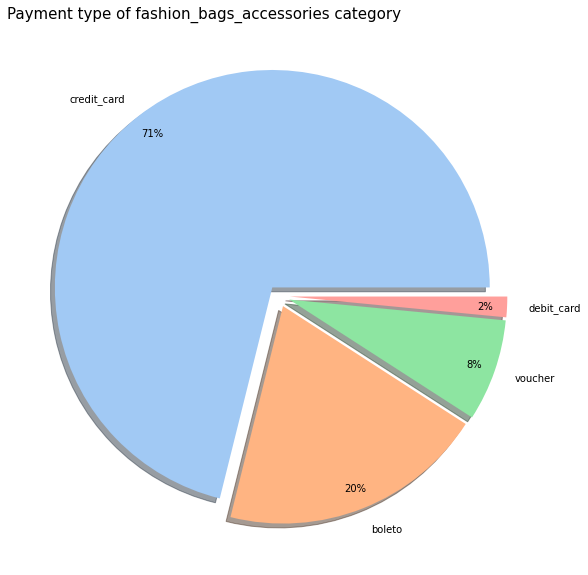

In [25]:
# PIE CHART OF METHOD OF PAYMENTS BY CATEGORY

payment_category_pie = payments_per_category[payments_per_category.product_category_name_english == categoria_metodo_pago].payment_type.value_counts()

fig = plt.subplots(figsize = (10,10))
plt.title("Payment type of {} category".format(categoria_metodo_pago), loc='left', fontdict = {'fontsize': 15})
explode = [0.05] * len(payment_category_pie)
labels = payment_category_pie.index
colors = sns.color_palette('pastel')
plt.pie(payment_category_pie.values, labels=labels, colors=colors, autopct = '%0.0f%%', shadow = 'True', pctdistance=0.9, explode = explode)
plt.show()


## Reviews

### Dynamic pie chart of reviews by category

In [26]:
categoria = 'health_beauty'

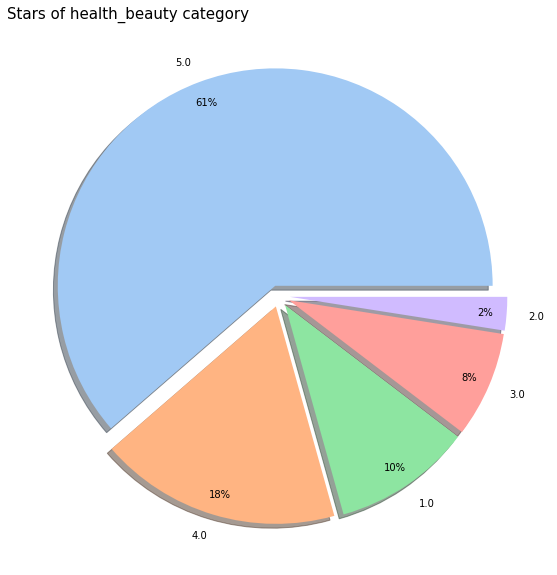

In [27]:
# PIE CHART OF REVIEWS BY CATEGORY

reviews_score_pie = reviews_per_category[reviews_per_category.product_category_name_english == categoria].review_score.value_counts()

fig = plt.subplots(figsize = (10,10))
colors = sns.color_palette('pastel')
plt.title("Stars of {} category".format(categoria), loc='left', fontdict = {'fontsize': 15})
explode = [0.05] * len(reviews_score_pie)
labels = reviews_score_pie.index
#reviews_score_pie.plot.pie(colors = colors, autopct = '%0.0f%%', shadow = 'True', pctdistance=0.9, explode = explode)
plt.pie(reviews_score_pie.values, labels = labels, colors = colors, autopct = '%0.0f%%', shadow = 'True', pctdistance=0.9, explode = explode)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1a605b69-dba5-410f-813d-454a0a9051ce' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>